In [46]:
import os
import gym
from gym import spaces

import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
import math
from scipy.stats import unitary_group
import scipy as scp
import networkx as nx
import torch as th

from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import CheckpointCallback, EveryNTimesteps

from stable_baselines3.common import results_plotter
from stable_baselines3.common.results_plotter import load_results, ts2xy

In [7]:
#COMMON GATES
H = np.array([[1,1],[1,-1]])/np.sqrt(2)
S = np.array([[1,0],[0,1j]])
Pi8 = np.array([[1,0],[0,np.exp(1j*np.pi/4)]])
sx = np.array([[0,1],[1,0]])
sz = np.array([[1,0],[0,-1]])

#COMMON QUANTUM STATES
q_zero = np.array([[1],[0]])
qubit_plus = H@q_zero

def moving_average(x, w):
    """
    Smooths data x over a window w
    """
    ps = np.repeat(1.0, w) / w
    return np.convolve(x, ps, 'valid')


def plot_results(log_folder, title, w=50):
    """
    Plots learning curve using the log of PPO from stable_baselines3
    """
    x, y = ts2xy(load_results(log_folder), 'timesteps')
    y = moving_average(y, w)
    x = x[len(x) - len(y):]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel('Steps')
    plt.ylabel('Average Fidelity')
    plt.title(title)
    plt.show()
    
def cnot_ij(i,j,n):
    """
    CNOT gate with 
    i: control qubit
    j: target qubit
    n: number of qubits
    """
    op1,op2,op3,op4 = np.ones(4)
    for k in range(1,n+1):
        if k==i or k==j:
            op1 = np.kron(op1,np.kron(np.array([[1],[0]]).T, np.array([[1],[0]])))
        else:
            op1 = np.kron(op1, np.eye(2))        
        if k == i:
            op2 = np.kron(op2,np.kron(np.array([[1],[0]]).T, np.array([[1],[0]])))
            op3 = np.kron(op3,np.kron(np.array([[0],[1]]).T, np.array([[0],[1]])))
            op4 = np.kron(op4,np.kron(np.array([[0],[1]]).T, np.array([[0],[1]])))
        elif k==j:
            op2 = np.kron(op2,np.kron(np.array([[0],[1]]).T, np.array([[0],[1]])))
            op3 = np.kron(op3,np.kron(np.array([[1],[0]]).T, np.array([[0],[1]])))
            op4 = np.kron(op4,np.kron(np.array([[0],[1]]).T, np.array([[1],[0]])))
        else:
            op2 = np.kron(op2, np.eye(2))
            op3 = np.kron(op3, np.eye(2))
            op4 = np.kron(op4, np.eye(2))

    return op1+op2+op3+op4

class mbqc_env(gym.Env):
    """
    This class is the environment used by the RL agents to interact with. The important methods are __init__(), step(), and reset(). These     correspond to the initialization of the quantum resource state, the single-qubit measurements, and the reset of the environment 
    respectively  
    """
    metadata = {'render.modes': ['human']}
    
    def __init__(self, n_qubits, width, graph, flow, unitary, noise=0, noise_type="random" ,test_fidelity=False, init_state_random = True, input_state_indxs = [-1], output_state_indxs=[-1], intermediate_reward=False):
        """
        n_qubits: number of qubits that are measured
        width: width of cluster state
        graph: graph from networkx defining the resource state
        flow: it is a function that defines the flow on the graph
        unitary: gate that we want to learn to implement
        noise: noise strength
        noise_type: can be "random", "bitflip", or "none"
        test_fidelity: if true, it calculates the fidelity of a circuit with no noise
        init_state_random = if true, initial state is random, if false, initial state is |0>^{\otimes n}
        input_states_indxs = if its [-1], the input state will be located in first (width)-th nodes and will use an
                                extra qubit located in node (width+1). Otherwise, the first (width) elements of the list
                                will correspond to the input state and the (width+1) element to the extra ancilla used.
        output_states_indxs = if its [-1], the output state will be locateed in the last (width)-th nodes. Otherwise. the
                                elements in this list will be the the index of the output state. 
        intermediate_reward = if True, reward is given every step, if False, reward is given only at the end of the measurment pattern
        """
        self.n_qubits = n_qubits
        self.width = width
        
        self.graph = graph
        self.flow = flow
        
        self.unitary = unitary
        self.noise = noise
        self.noise_type = noise_type
        self.test_fidelity = test_fidelity
        self.init_state_random = init_state_random
        self.intermediate_reward = intermediate_reward

        #define action and observation space that is given to the RL agent
        self.action_space = spaces.Box(low = np.array([-1*(np.pi+0.1)]), high=np.array([1*(np.pi+0.1)]) )
        self.observation_space = spaces.Box(low=np.array([0,-np.pi-0.1,0]) , high=np.array([50,np.pi+0.1,1]))
        
        
        self.state = np.zeros(3)
        self.total_measurements = self.n_qubits
        self.measurements_left = self.n_qubits
        
        
        q_zeros = 1
        for i in range(self.width):
            q_zeros = np.kron(q_zeros,H@q_zero)
        
        if self.init_state_random:
            st = unitary_group.rvs(2**self.width)@q_zeros
        elif not self.init_state_random:
            st = np.eye(2**self.width)@q_zeros
        
        #NOISE MODELS
        #--------------------------------------------------------------------------------------------
        if self.noise_type=="random":
            noisyU = self.randomUnitary_closetoid(2**self.width,self.noise,20)
            self.final_qstate_train = self.pure2density(noisyU@self.unitary@(np.conj(noisyU.T))@st)
        elif self.noise_type=="bitflip":
            errs = np.random.choice([0,1],p=[1-self.noise, self.noise])
            if errs==0:
                self.final_qstate_train = self.pure2density(self.unitary@st)
            elif errs==1:
                sxs = 1
                for i in range(self.width):
                    sxs = np.kron(sxs, sx)
                self.final_qstate_train = self.pure2density(sxs@self.unitary@st)
        elif self.noise_type=="none":
            self.final_qstate_train = self.pure2density(self.unitary@st)    
        #--------------------------------------------------------------------------------------------

        self.final_qstate_test = self.pure2density(self.unitary@st)

        if input_state_indxs == [-1]:
            self.input_state_indices = list(range(self.width+1))
        else:
            self.input_state_indices = input_state_indxs
           
        if output_state_indxs ==[-1]:
            self.output_state_indices = list(range(n_qubits, n_qubits+width))
        else:
            self.output_state_indices = output_state_indxs
            
        assert len(self.input_state_indices)==self.width+1, "ERROR WITH INPUT STATE INDICES"

        subgr = self.graph.subgraph(self.input_state_indices).copy()
        mapping = {nod:idx for idx,nod in enumerate(self.input_state_indices)}
        subgr = nx.relabel_nodes(subgr, mapping)

        self.current_simulated_nodes = np.array(self.input_state_indices)
        self.qstate = self.pure2density(self.graph_with_multiple_inputs(subgr, inputstates=st, width=self.width))

    def step(self, action):
        """
        Step function with the convention of the gym library
        It measures the current qubit with an angle of (action)
        """
        
        current_measurement = np.min(self.current_simulated_nodes)
        self.measurements_left -= 1
        
        qubit_to_measure = np.argmin(self.current_simulated_nodes)
        self.qstate, outcome = self.measure_angle(self.qstate, action[0] , qubit_to_measure)

        self.state = np.array([current_measurement+1,action[0],outcome]) 

        if outcome == 1:
            fi = self.flow(current_measurement)
            assert fi in self.current_simulated_nodes, "ERROR WITH FLOW"
            modified_qubit  = np.where(np.array(self.current_simulated_nodes)==fi)[0][0]
            self.qstate = self.arbitrary_qubit_gate(sx,modified_qubit,self.width+1)@self.qstate@np.conj(self.arbitrary_qubit_gate(sx,modified_qubit,self.width+1).T)
            
            for ne in self.graph.neighbors(fi):
                if ne in self.current_simulated_nodes and ne!=current_measurement:
                    self.qstate = self.arbitrary_qubit_gate(sz,ne-current_measurement,self.width+1)@self.qstate@np.conj(self.arbitrary_qubit_gate(sz,ne-current_measurement,self.width+1).T)
            

        self.qstate = self.partial_trace(self.qstate, [qubit_to_measure])
        self.current_simulated_nodes = np.delete(self.current_simulated_nodes, np.where(self.current_simulated_nodes==current_measurement))
        #np.setdiff1d(self.current_simulated_nodes, current_measurement)
        
        reward = 0 #fidelity
        
        
        ### INTERMEDIATE STATE FIDELITY
        if self.intermediate_reward:
            if not self.test_fidelity:
                reward = self.fidelity(self.final_qstate_train, self.sort_state())
            elif self.test_fidelity:
                reward = self.fidelity(self.final_qstate_test, self.sort_state())

        new_qubit_indx = self.flow(np.min(self.current_simulated_nodes))
        err_temp = False
        if new_qubit_indx in self.current_simulated_nodes:
            err_temp = True
        elif new_qubit_indx in list(self.graph.nodes()):
            self.current_simulated_nodes = np.append(self.current_simulated_nodes, [new_qubit_indx])

        if self.measurements_left!=0:
            if err_temp:
                print("ERROR, CHECK FLOW?")
            self.qstate = np.kron(self.qstate, self.pure2density(qubit_plus))
            for ne in self.graph.neighbors(new_qubit_indx):
                if ne in self.current_simulated_nodes:
                    q1 = np.where(self.current_simulated_nodes==ne)[0][0]
                    q2 = np.where(self.current_simulated_nodes==new_qubit_indx)[0][0]
                    #print("q1 and q2:", q1, q2)
                    cgate=self.controlled_z(q1,q2, self.width+1)
                    self.qstate = cgate@self.qstate@np.conj(cgate.T)      
        
        if self.measurements_left == 0:  
            
            self.qstate = self.sort_state()
            
            if not self.test_fidelity:
                reward = self.fidelity(self.final_qstate_train, self.qstate)
            elif self.test_fidelity:
                reward = self.fidelity(self.final_qstate_test, self.qstate)
            done = True
        else:
            done = False
        
        info = {}

        return self.state, reward, done, info
        
        
    def reset(self):
        """
        Resets MDP.
        """
        self.state = np.zeros(3)
        self.total_measurements = self.n_qubits
        self.measurements_left = self.n_qubits
        
        q_zeros = 1
        for i in range(self.width):
            q_zeros = np.kron(q_zeros, H@q_zero)
        
        if self.init_state_random:
            st = unitary_group.rvs(2**self.width)@q_zeros
        elif not self.init_state_random:
            st = np.eye(2**self.width)@q_zeros
        
        if self.noise_type=="random":
            noisyU = self.randomUnitary_closetoid(2**self.width,self.noise,20)
            self.final_qstate_train = self.pure2density(noisyU@self.unitary@(np.conj(noisyU.T))@st)
        elif self.noise_type=="bitflip":
            errs = np.random.choice([0,1],p=[1-self.noise, self.noise])
            if errs==0:
                self.final_qstate_train = self.pure2density(self.unitary@st)
            elif errs==1:
                sxs = 1
                for i in range(self.width):
                    sxs = np.kron(sxs, sx)
                self.final_qstate_train = self.pure2density(sxs@self.unitary@st)
        elif self.noise_type=="none":
            self.final_qstate_train = self.pure2density(self.unitary@st)
            
        self.final_qstate_test = self.pure2density(self.unitary@st)
        

        subgr = self.graph.subgraph(self.input_state_indices).copy()
        mapping = {nod:idx for idx,nod in enumerate(self.input_state_indices)}
        subgr = nx.relabel_nodes(subgr, mapping)

        self.current_simulated_nodes = np.array(self.input_state_indices)
            
        self.qstate = self.pure2density(self.graph_with_multiple_inputs(subgr, inputstates=st, width=self.width))
        
        return self.state
        
    def render(self, mode='human', close=False):
        pass

    def controlled_z(self, i, j , n):
        """
        Controlled z gate between qubits i and j. 
        n is the total number of qubits
        """
        assert i<n and j<n
        op1, op2 = 1, 2
        for k in range(0,n):
            op1 = np.kron(op1, np.eye(2))
            if k in [i,j]:
                op2 = np.kron(op2, np.kron(np.conjugate(np.array([[0],[1]]).T), np.array([[0],[1]])))
            else:
                op2 = np.kron(op2, np.eye(2))
        return op1-op2

    def fidelity(self, sigma, rho):
        """
        Calculates fidelity between sigma and rho (density matrices)
        """
        srho = linalg.sqrtm(rho)
        prod = srho@sigma@srho
        sprod = linalg.sqrtm(prod)
        return np.abs(np.trace(sprod))

    def pure2density(self, psi):
        """
        Input: quantum state
        Output: corresponding density matrix
        """
        return np.kron(psi, np.conjugate(psi.T))

    def measure_angle(self, rho, angle, i):
        """
        Measures qubit i of state rho with an angle 
        """
        n = self.width+1
        pi0 = 1
        pi1 = 1
        pi0op = np.array([[1, np.exp(-angle*1j)],[np.exp(angle*1j), 1]])/2
        pi1op = np.array([[1,-np.exp(-angle*1j)],[-np.exp(angle*1j), 1]])/2
        for k in range(0,n):
            if k == i:
                pi0 = np.kron(pi0, pi0op)
                pi1 = np.kron(pi1, pi1op)
            else:
                pi0 = np.kron(pi0, np.eye(2))
                pi1 = np.kron(pi1, np.eye(2))
        prob0, prob1 = np.real(np.trace(rho@pi0)), np.real(np.trace(rho@pi1))
        measurement = np.random.choice([0,1], p=[prob0,prob1]/(prob0+prob1))
        
        #FORCE OUTCOME TO BE 0
        measurement = 0
        
        if measurement==0:
            rho = pi0@rho@pi0/prob0
        elif measurement==1:
            rho = pi1@rho@pi1/prob1
            
        return rho, measurement

   
    def partial_trace(self, rho, indices):
        """
        Partial trace of state rho over some indices 
        """
        x,y = rho.shape
        n = int(math.log(x,2))
        r = len(indices)
        sigma = np.zeros((int(x/(2**r)), int(y/(2**r))))
        for m in range(0, 2**r):
            qubits = format(m,'0'+f'{r}'+'b')
            ptrace = 1
            for k in range(0,n):
                if k in indices:
                    idx = indices.index(k)
                    if qubits[idx]=='0':
                        ptrace = np.kron(ptrace, np.array([[1],[0]]))
                    elif qubits[idx]=='1':
                        ptrace = np.kron(ptrace, np.array([[0],[1]]))
                else:
                    ptrace = np.kron(ptrace, np.eye(2))
            sigma = sigma + np.conjugate(ptrace.T)@rho@(ptrace)
        return sigma


    def graph_state(self, G):
        """
        Creates a graph state with graph G
        """
        n = G.number_of_nodes()
        psi = 1
        for i in range(n):
            psi = np.kron(psi, qubit_plus)
        for j in list(G.edges()):
            psi = self.controlled_z(j[0],j[1], n)@psi
        return psi
                                    
                                    
    def graph_with_multiple_inputs(self, G, inputstates=1, width=0):
        """
        Creates a graph state with inputs where G is the graph
        """
        n = G.number_of_nodes()
        psi = 1
        if self.width==0:
            psi = self.graph_state(G)
        else:
            psi = np.kron(psi, inputstates)
            psi = np.kron(psi, qubit_plus)

        for j in list(G.edges()):
            psi = self.controlled_z(j[0],j[1], n)@psi

        return psi 
                                

    def arbitrary_qubit_gate(self,u,i,n):
        """
        Single qubit gate u acting on qubit i
        n is the number of qubits
        """
        op = 1
        for k in range(n):
            if k==i:
                op = np.kron(op, u)
            else:
                op = np.kron(op, np.eye(2))
        return op
    
    def swap_ij(self,i,j,n):
        """
        Swaps qubit i with qubit j
        """
        assert i<n and j<n
        op1,op2,op3,op4 = np.ones(4)
        for k in range(n):
            if k==i or k==j:
                op1 = np.kron(op1,np.kron(np.array([[1],[0]]).T, np.array([[1],[0]])))
                op4 = np.kron(op4,np.kron(np.array([[0],[1]]).T, np.array([[0],[1]])))
            else:
                op1 = np.kron(op1, np.eye(2))
                op4 = np.kron(op4, np.eye(2))

            if k == i:
                op2 = np.kron(op2,np.kron(np.array([[1],[0]]).T, np.array([[0],[1]])))
                op3 = np.kron(op3,np.kron(np.array([[0],[1]]).T, np.array([[1],[0]])))
            elif k==j:
                op2 = np.kron(op2,np.kron(np.array([[0],[1]]).T, np.array([[1],[0]])))
                op3 = np.kron(op3,np.kron(np.array([[1],[0]]).T, np.array([[0],[1]])))
            else:
                op2 = np.kron(op2, np.eye(2))
                op3 = np.kron(op3, np.eye(2))
        return op1+op2+op3+op4
    
    def brownian_circuit(self,dim, n, dt):
        u = np.eye(dim)
        for j in range(n):
            re = np.random.normal(size=(dim,dim))
            im = 1j*np.random.normal(size=(dim,dim))
            c = re + im
            h = (c+np.conj(c.T))/4
            u = u@scp.linalg.expm(1j*h*dt)
        return u

    def randomUnitary_closetoid(self,dim, t, n):
        return self.brownian_circuit(dim,n, np.sqrt(1/(n*dim))*2*np.pi*t)
    
    
    def sort_state(self):
        sorted_state = self.qstate.copy()
        sorted_nodes = self.current_simulated_nodes.copy()
        sorted_nodes.sort()
        if (self.current_simulated_nodes==sorted_nodes).all():
            pass
        else:
            sim_nodes = self.current_simulated_nodes.copy()
            for n_iteret in range(1,len(sim_nodes)):
                ll = np.argmin(sim_nodes[:-n_iteret])
                sim_nodes[n_iteret], sim_nodes[ll+n_iteret] =sim_nodes[ll+n_iteret], sim_nodes[n_iteret]  
                #print("ll+n_iteret-1:", ll+n_iteret-1, "\nn_iteret:", n_iteret, "\nlensimnodes", len(sim_nodes))
                swapgate = self.swap_ij(ll+n_iteret-1,n_iteret,len(sim_nodes))
                sorted_state =swapgate@sorted_state@np.conj(swapgate.T)
        return sorted_state


In [35]:
#define our graph
gr = nx.Graph()
gr.add_nodes_from(list(range(5)))
gr.add_edges_from([(0, 1),(1,2),(2,3),(3,4)])

#pick a one-qubit unitary gate to learn
unitary_random = unitary_group.rvs(2)

In [9]:
#create environment and path for log file
env = mbqc_env(4, 1, gr, lambda x: x+1, unitary_random, noise=0, noise_type="none" ,test_fidelity=False, init_state_random = True, intermediate_reward=False)
log_dir = "./logs/logs1"
os.makedirs(log_dir, exist_ok=True)
env = Monitor(env, log_dir)
checkpoint_on_event = CheckpointCallback(save_freq=1, save_path=log_dir)
event_callback = EveryNTimesteps(n_steps=1000, callback=checkpoint_on_event)

In [10]:
#define and train the model
model = PPO("MlpPolicy", env, verbose=0);
model.learn(total_timesteps=int(1e5), callback=event_callback)

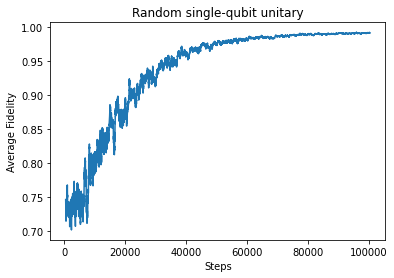

In [11]:
#plot learning curve of the agent
plot_results(log_dir, title="Random single-qubit unitary",w=100)

In [36]:
#create environment and path for log file
env = mbqc_env(4, 1, gr, lambda x: x+1, unitary_random, noise=0, noise_type="none" ,test_fidelity=False, init_state_random = True, intermediate_reward=False)
log_dir = "./logs/logs1"
os.makedirs(log_dir, exist_ok=True)
env = Monitor(env, log_dir)
checkpoint_on_event = CheckpointCallback(save_freq=1, save_path=log_dir)
event_callback = EveryNTimesteps(n_steps=1000, callback=checkpoint_on_event)

C:\Users\luism\anaconda3\envs\gym\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


In [37]:
#define and train the model
model = PPO("MlpPolicy", env, verbose=0);
model.learn(total_timesteps=int(1e5), callback=event_callback)

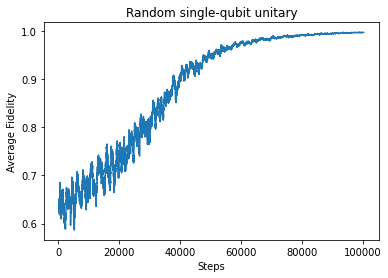

In [38]:
#plot learning curve of the agent
plot_results(log_dir, title="Random single-qubit unitary",w=100)

In [ ]:
#define graph topology
gr = nx.Graph()
gr.add_nodes_from(list(range(22)))

gr.add_edges_from([(0, 2), (2, 4), (4,6), (6,8),(8,10), (10,12),(12,14), (6,7), 
                 (1,3),(3,5),(5,7),(7,9),(9,11),(11,13),(13,15), (14,15), (14,16),(15,17),(16,18),(17,19),
                   (18,20),(19,21)])

#plots graph state
fig = plt.figure(1, figsize=(8, 8))
xpp = nx.spring_layout(gr)
color_map = []
for node in gr:
    if node in [0,1]:
        color_map.append('green')
    elif node in [20,21]:
        color_map.append('red')
    else: 
        color_map.append('blue')
nx.draw(gr,node_color=color_map, with_labels = True,font_color="whitesmoke")
plt.axis('off');

In [ ]:
unitary_random2 = unitary_group.rvs(4)

In [ ]:
#create environment and path for log file
env2 = mbqc_env(20, 2, gr, lambda x: x+2, unitary_random2, noise=0, noise_type="none" ,test_fidelity=False, init_state_random = True, intermediate_reward=False)

log_dir2 = "./logs/logs2/"
os.makedirs(log_dir2, exist_ok=True)
env2 = Monitor(env2, log_dir2)

checkpoint_on_event = CheckpointCallback(save_freq=1, save_path=log_dir2)
event_callback = EveryNTimesteps(n_steps=1000, callback=checkpoint_on_event)

In [ ]:
#Define and train the agent
policy_kwargs = dict(activation_fn=th.nn.ReLU,
                     net_arch=[dict(pi=[64, 64,64], vf=[64,64,64])])

model2 = PPO("MlpPolicy", env2,policy_kwargs=policy_kwargs, verbose=0)
model2.learn(total_timesteps=int(4e5), callback=event_callback)

In [ ]:
#plot learning curve of CNOT
plot_results(log_dir2, title="Arbitrary gate", w=100)

In [25]:
#create environment and path for log file
env2 = mbqc_env(20, 2, gr, lambda x: x+2, unitary_random2, noise=0, noise_type="none" ,test_fidelity=False, init_state_random = True, intermediate_reward=True)

log_dir2 = "./logs/logs2/"
os.makedirs(log_dir2, exist_ok=True)
env2 = Monitor(env2, log_dir2)

checkpoint_on_event = CheckpointCallback(save_freq=1, save_path=log_dir2)
event_callback = EveryNTimesteps(n_steps=1000, callback=checkpoint_on_event)

C:\Users\luism\anaconda3\envs\gym\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


In [28]:
#Define and train the agent
model2 = PPO("MlpPolicy", env2, verbose=0)
model2.learn(total_timesteps=int(4e5), callback=event_callback)

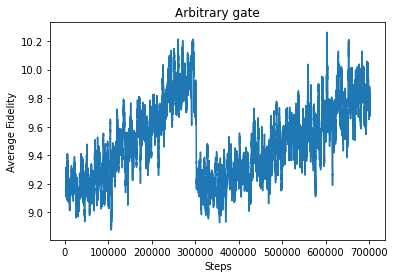

In [29]:
#plot learning curve of CNOT
plot_results(log_dir2, title="Arbitrary gate", w=100)

In [39]:
def controlled_unitary(i, j,u, n):
    """
    controlled_unitary gate with 
    i: control qubit
    j: target qubit
    u: unitary gate
    n: number of qubits
    """
    op1,op2,op3,op4 = np.ones(4)
    for k in range(1,n+1):
        if k==i or k==j:
            op1 = np.kron(op1,np.kron(np.array([[1],[0]]).T, np.array([[1],[0]])))
        else:
            op1 = np.kron(op1, np.eye(2))        
        if k == i:
            op2 = np.kron(op2,np.kron(np.array([[1],[0]]).T, np.array([[1],[0]])))
            op3 = np.kron(op3,np.kron(np.array([[0],[1]]).T, np.array([[0],[1]])))
            op4 = np.kron(op4,np.kron(np.array([[0],[1]]).T, np.array([[0],[1]])))
        elif k==j:
            op2 = np.kron(op2,np.kron(np.array([[0],[1]]).T, np.array([[0],[1]])))
            op3 = np.kron(op3,np.kron(np.array([[1],[0]]).T,u[0,0]*np.array([[1],[0]])+u[1,0]*np.array([[0],[1]])))
            op4 = np.kron(op4,np.kron(np.array([[0],[1]]).T, u[0,1]*np.array([[1],[0]])+u[1,1]*np.array([[0],[1]])))
        else:
            op2 = np.kron(op2, np.eye(2))
            op3 = np.kron(op3, np.eye(2))
            op4 = np.kron(op4, np.eye(2))

    return op1+op2+op3+op4

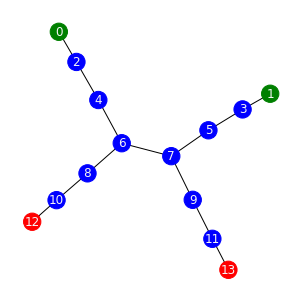

In [40]:
#define graph topology
gr = nx.Graph()
gr.add_nodes_from(list(range(2,14)))
gr.add_edges_from([(0, 2), (2, 4), (4,6), (6,8),(8,10), (10,12), (6,7), 
                 (1,3),(3,5),(5,7),(7,9),(9,11),(11,13)])

#plots graph state
fig = plt.figure(1, figsize=(4, 4))
xpp = nx.spring_layout(gr)
color_map = []
for node in gr:
    if node in [0,1]:
        color_map.append('green')
    elif node in [12,13]:
        color_map.append('red')
    else: 
        color_map.append('blue')
nx.draw(gr,node_color=color_map, with_labels = True,font_color="whitesmoke")
plt.axis('off');

In [47]:
#create environment and path for log file
env2 = mbqc_env(12, 2, gr, lambda x: x+2,  cnot_ij(1,2,2), noise=0, noise_type="none" ,test_fidelity=False, init_state_random = True, intermediate_reward= False)

#env2 = mbqc_env(12, 2, gr, ff2, cnot_ij(1,2,2), noise=0, noise_type="none" ,test_fidelity=False, init_state_random = True, input_state_indxs=[1,0,2])

log_dir2 = "./logs/logs2/"
os.makedirs(log_dir2, exist_ok=True)
env2 = Monitor(env2, log_dir2)

checkpoint_on_event = CheckpointCallback(save_freq=1, save_path=log_dir2)
event_callback = EveryNTimesteps(n_steps=1000, callback=checkpoint_on_event)

In [ ]:
#Define and train the agent
policy_kwargs = dict(activation_fn=th.nn.ReLU,
                     net_arch=[dict(pi=[64, 64], vf=[64, 64])])

model2 = PPO("MlpPolicy", env2,policy_kwargs=policy_kwargs, verbose=0)
model2.learn(total_timesteps=int(4e5), callback=event_callback)

In [ ]:
#plot learning curve of CNOT
plot_results(log_dir2, title="[CNOT]", w=100)

In [ ]:
#create environment and path for log file
env2 = mbqc_env(12, 2, gr, lambda x: x+2,  cnot_ij(1,2,2), noise=0, noise_type="none" ,test_fidelity=False, init_state_random = True, intermediate_reward= False)

#env2 = mbqc_env(12, 2, gr, ff2, cnot_ij(1,2,2), noise=0, noise_type="none" ,test_fidelity=False, init_state_random = True, input_state_indxs=[1,0,2])

log_dir2 = "./logs/logs2/"
os.makedirs(log_dir2, exist_ok=True)
env2 = Monitor(env2, log_dir2)

checkpoint_on_event = CheckpointCallback(save_freq=1, save_path=log_dir2)
event_callback = EveryNTimesteps(n_steps=1000, callback=checkpoint_on_event)

In [ ]:
#Define and train the agent
policy_kwargs = dict(activation_fn=th.nn.ReLU,
                     net_arch=[dict(pi=[32, 32,32], vf=[32,32,32])])

model2 = PPO("MlpPolicy", env2,policy_kwargs=policy_kwargs, verbose=0)
model2.learn(total_timesteps=int(4e5), callback=event_callback)

In [ ]:
#plot learning curve of CNOT
plot_results(log_dir2, title="[CNOT]", w=100)